# Neural Networks with PyTorch

In this tutorial we will show how to create a Neural Network
using the PyTorch (more usage examples of PyTorch [here](
https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)).

## Classifying blobs

First, we need to create a neural network. We simply 
use PyTorch `nn.Module` as regular PyTorch code.

In [1]:
import torch
from torch import nn

class Net(nn.Module):
    """
    Model with input size (-1, 5) for blobs dataset
    with 5 features
    """
    def __init__(self, n_features, n_classes):
        """Example network."""
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 5)
        self.fc2 = nn.Linear(5, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

We will use a 5D dataset composed with 3 gaussians. We can use 4k samples for 
training and 1k for testing. We can divide the sets in batches so that they can 
be processed in small groups by the network. We use a batch size of 20.

In [2]:
# experiment parameters
n_classes = 3
n_features = 2
n_samples_tr = 4000  # number of training set samples
n_samples_ts = 1000  # number of testing set samples
batch_size = 20

# dataset creation
from secml.data.loader import CDLRandom
dataset = CDLRandom(n_samples=n_samples_tr + n_samples_ts,
                    n_classes=n_classes,
                    n_features=n_features, n_redundant=0,
                    n_clusters_per_class=1,
                    class_sep=1, random_state=0).load()

# Split in training and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(train_size=n_samples_tr, 
                           test_size=n_samples_ts,
                           random_state=0)

tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features.normalization import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

Now we can create an instance of the PyTorch model and then wrap it in the 
specific class that will link it to our library functionalities.

In [3]:
# torch model creation
net = Net(n_features=n_features, n_classes=n_classes)

from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.01, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         input_shape=(n_features,))

We can simply use the loaded `CDataset` and pass it to the `fit` method. The 
wrapper will handle batch processing and train the network for the number of epochs 
specified in the wrapper constructor.

In [4]:
clf.fit(tr)

[1,  2000] loss: 0.420
[1,  4000] loss: 0.116
[2,  2000] loss: 0.083
[2,  4000] loss: 0.095
[3,  2000] loss: 0.079
[3,  4000] loss: 0.092
[4,  2000] loss: 0.076
[4,  4000] loss: 0.088
[5,  2000] loss: 0.074
[5,  4000] loss: 0.086
[6,  2000] loss: 0.072
[6,  4000] loss: 0.085
[7,  2000] loss: 0.070
[7,  4000] loss: 0.084
[8,  2000] loss: 0.068
[8,  4000] loss: 0.083
[9,  2000] loss: 0.067
[9,  4000] loss: 0.083
[10,  2000] loss: 0.066
[10,  4000] loss: 0.082


CClassifierPyTorch{'classes': CArray(3,)(dense: [0 1 2]), 'n_features': 2, 'preprocess': None, 'input_shape': (2,), 'softmax_outputs': False, 'loss': CrossEntropyLoss(), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), 'epochs': 10, 'batch_size': 1}

Using the model in "predict" mode is just as easy. We can use the method `predict` 
defined in our wrapper, and pass in the data. We can evaluate the accuracy with 
the `CMetric` defined in our library.

In [5]:
label_torch = clf.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
acc_torch = CMetric.create('accuracy').performance_score(ts.Y, label_torch)

print("Model Accuracy: {}".format(acc_torch))

Model Accuracy: 0.991


# Evasion Attacks against Neural Networks on MNIST dataset

Now we do the same thing with the MNIST dataset. We can use a convolutional 
neural network, but we need to take care of reshaping the input to the expected 
input size - in this case (-1, 1, 28, 28). We will see in the following how to 
use torchvision's `transforms` module for this.


In [6]:
class MNISTNet(nn.Module):
    """
    Model with input size (-1, 28, 28) for MNIST dataset.
    """
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
    

Now we can load MNIST dataset. Here we should take care of the conversion from 
1D vector to images of shape (-1, 1, 28, 28). This is a required step, since 
the loader defined in our library is defined to load a ravel vector with shape (-1, 1, 784).

We can use a `Lambda` module of the `transforms` package from `torchvision`. The lambda 
we define will simply reshape the tensors to the shape expected by our network.

In [7]:
n_samples_tr = 6000  # number of training set samples
n_samples_ts = 1000  # number of testing set samples

from secml.data.loader import CDataLoaderMNIST
digits = (1, 5, 9)
dataset = CDataLoaderMNIST().load('training', digits=digits)

# Split in training and test
splitter = CTrainTestSplit(train_size=n_samples_tr, 
                           test_size=n_samples_ts,
                           random_state=0)
tr, ts = splitter.split(dataset)

# Normalize the data
nmz = CNormalizerMinMax()
tr.X /= 255
ts.X /= 255

Now we can use again the `CClassifierPyTorch` wrapper for having the model 
accessible with our library.

In [8]:
net = MNISTNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),
                      lr=0.001, momentum=0.9)

clf = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=20,
                         batch_size=20,
                         input_shape=(1, 28, 28))

We fit the model in the same way as before.

In [9]:
clf.fit(tr)


CClassifierPyTorch{'classes': CArray(3,)(dense: [0 1 2]), 'n_features': 784, 'preprocess': None, 'input_shape': (1, 28, 28), 'softmax_outputs': False, 'loss': CrossEntropyLoss(), 'optimizer': SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
), 'epochs': 20, 'batch_size': 20}

And now we can check how well we can classify the digits.

In [10]:
label_torch = clf.predict(ts.X, return_decision_function=False)

metric = CMetric.create('accuracy')
acc_torch = metric.performance_score(ts.Y, label_torch)

print("Model Accuracy: {}".format(acc_torch))


Model Accuracy: 0.989


## Crafting Evasion Attacks

We can now create, as we did in notebook `05-MNIST_dataset.ipynb`, adversarial examples 
against the neural network we just trained. The code is similar to the other notebook, 
the only difference will be the classifier that we pass to the `CAttackEvasionPGDLS` 
object.

In [11]:

# For simplicity, let's attack a subset of the test set
attack_ds = ts[:25, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 3.  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.3, 
    'eta_min': 2.0, 
    'eta_max': None,
    'max_iter': 100, 
    'eps': 1e-4
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    surrogate_classifier=clf,
                                    surrogate_data=tr,
                                    distance=noise_type, 
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds.X, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [12]:
acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=clf.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Accuracy on reduced test set before attack: 72.00%
Accuracy on reduced test set after attack: 36.00%


Finally, we can display the adversarial digit along with its label.

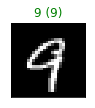

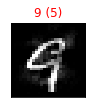

In [14]:
from secml.figure import CFigure
# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

show_digits(attack_ds.X[0, :], clf.predict(attack_ds.X[0, :]), attack_ds.Y[0, :], digits)
show_digits(eva_adv_ds.X[0, :], clf.predict(eva_adv_ds.X[0, :]), eva_adv_ds.Y[0, :], digits)